In [1]:
!pip install -r requirements.txt

  Cloning https://github.com/huggingface/peft.git to /tmp/pip-req-build-pnrggn9v
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/peft.git /tmp/pip-req-build-pnrggn9v
  Resolved https://github.com/huggingface/peft.git to commit 679bcd8777fc8215208bc46b7f54f1f4061791ae
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.9 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━

In [2]:
from transformers import pipeline
from nltk import sent_tokenize
import nltk
import torch
from glob import glob
import pandas as pd
import numpy as np

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Load Model

In [4]:
model_name = "facebook/bart-large-mnli"
device = 0 if torch.cuda.is_available() else 'cpu'

In [5]:
def load_model(device):
    theme_classifier = pipeline(
        "zero-shot-classification",
        model=model_name,
        device=device
    )

    return theme_classifier

In [6]:
theme_classifier = load_model(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
theme_list = ["friendship","hope","sacrifice","battle","self development","betrayal","love","dialogue"]

In [8]:
theme_classifier(
    "I gave him a right hook then a left jab",
    theme_list,
    multi_label=True
)

{'sequence': 'I gave him a right hook then a left jab',
 'labels': ['battle',
  'self development',
  'hope',
  'sacrifice',
  'dialogue',
  'betrayal',
  'love',
  'friendship'],
 'scores': [0.9121254086494446,
  0.47500181198120117,
  0.0878182053565979,
  0.045000456273555756,
  0.020132921636104584,
  0.012040475383400917,
  0.0042923809960484505,
  0.002817221451550722]}

# Load Dataset


In [9]:
files = glob('../data/Subs/*.ass')

In [10]:
files[:5]

['Subtitles/Naruto Season 8 - 185.ass',
 'Subtitles/Naruto Season 4 - 99.ass',
 'Subtitles/Naruto Season 8 - 193.ass',
 'Subtitles/Naruto Season 8 - 206.ass',
 'Subtitles/Naruto Season 9 - 219.ass']

In [11]:
with open(files[0],'r') as file:
    lines = file.readlines()
    lines = lines[27:]
    lines =  [ ",".join(line.split(',')[9:])  for line in lines ]

In [12]:
lines[:2]

['Rock away your existence,\n', 'Shouting that you are here…\n']

In [13]:
lines = [ line.replace('\\N',' ') for line in lines]


In [14]:
" ".join(lines[:10])

'Rock away your existence,\n Shouting that you are here…\n A new journey begins now.\n As we survived through the changing seasons,\n we gained knowledge and strength, (just looks like a survival game)\n But the forgotten memories,\n of the feelings abandoned within the flows of time,\n have also been lost.\n When sinking down, we learned loneliness.\n But now we’ve met each other, we are no longer alone.\n'

In [15]:
int(files[0].split('-')[-1].split('.')[0].strip())

185

In [16]:
def load_subtitles_dataset(dataset_path):
    subtitles_paths = glob(dataset_path+'/*.ass')

    scripts=[]
    episode_num=[]

    for path in subtitles_paths:

        #Read Lines
        with open(path,'r') as file:
            lines = file.readlines()
            lines = lines[27:]
            lines =  [ ",".join(line.split(',')[9:])  for line in lines ]

        lines = [ line.replace('\\N',' ') for line in lines]
        script = " ".join(lines)

        episode = int(path.split('-')[-1].split('.')[0].strip())

        scripts.append(script)
        episode_num.append(episode)

    df = pd.DataFrame.from_dict({"episode":episode_num, "script":scripts })
    return df

In [17]:
dataset_path = "../data/Subs"
df = load_subtitles_dataset(dataset_path)

In [18]:
df.head()


,episode,script
0,185,"Rock away your existence,\n Shouting that you ..."
1,99,We are Fighting Dreamers aiming high\n Fightin...
2,193,"Rock away your existence,\n Shouting that you ..."
3,206,"Fly into the wavy and twisted sky, into your h..."
4,219,"Fly into the wavy and twisted sky, into your h..."


# Run Model

In [19]:
script = df.iloc[0]['script']

In [20]:
script

"Rock away your existence,\n Shouting that you are here…\n A new journey begins now.\n As we survived through the changing seasons,\n we gained knowledge and strength, (just looks like a survival game)\n But the forgotten memories,\n of the feelings abandoned within the flows of time,\n have also been lost.\n When sinking down, we learned loneliness.\n But now we’ve met each other, we are no longer alone.\n Unveil your feelings, Those high emotions\n Those tears will change your fate.\n Pound your heartbeat against the darkness,\n We’re sure to meet, Under the same flag of pain\n Oh!\n Sorry, sorry.\n Was that some eagle poop just now?\n Nothing there, huh?\n Well, I worked up a sweat,\n so I guess I’ll go home and take a shower.\n A Legend from the Hidden Leaf: The Onbaa!\n I worked up a good sweat today too.\n What’s the deal, Akamaru?\n He says you smell bad, Naruto.\n Are you making sure to take a bath?\n Don’t be saying rude things!\n No, you seriously stink.\n Come to think of it

In [21]:
script_sentences = sent_tokenize(script)
script_sentences[:3]

['Rock away your existence,\n Shouting that you are here…\n A new journey begins now.',
 'As we survived through the changing seasons,\n we gained knowledge and strength, (just looks like a survival game)\n But the forgotten memories,\n of the feelings abandoned within the flows of time,\n have also been lost.',
 'When sinking down, we learned loneliness.']

In [22]:
# Batch Sentence
sentence_batch_size=20
script_batches = []
for index in range(0,len(script_sentences),sentence_batch_size):
    sent = " ".join(script_sentences[index:index+sentence_batch_size])
    script_batches.append(sent)

In [23]:
script_batches[:2]

['Rock away your existence,\n Shouting that you are here…\n A new journey begins now. As we survived through the changing seasons,\n we gained knowledge and strength, (just looks like a survival game)\n But the forgotten memories,\n of the feelings abandoned within the flows of time,\n have also been lost. When sinking down, we learned loneliness. But now we’ve met each other, we are no longer alone. Unveil your feelings, Those high emotions\n Those tears will change your fate. Pound your heartbeat against the darkness,\n We’re sure to meet, Under the same flag of pain\n Oh! Sorry, sorry. Was that some eagle poop just now? Nothing there, huh? Well, I worked up a sweat,\n so I guess I’ll go home and take a shower. A Legend from the Hidden Leaf: The Onbaa! I worked up a good sweat today too. What’s the deal, Akamaru? He says you smell bad, Naruto. Are you making sure to take a bath? Don’t be saying rude things! No, you seriously stink. Come to think of it…\n The poop from the eagle a mom

In [24]:
theme_output = theme_classifier(
    script_batches[:2],
    theme_list,
    multi_label=True
)

In [25]:
theme_output


[{'sequence': 'Rock away your existence,\n Shouting that you are here…\n A new journey begins now. As we survived through the changing seasons,\n we gained knowledge and strength, (just looks like a survival game)\n But the forgotten memories,\n of the feelings abandoned within the flows of time,\n have also been lost. When sinking down, we learned loneliness. But now we’ve met each other, we are no longer alone. Unveil your feelings, Those high emotions\n Those tears will change your fate. Pound your heartbeat against the darkness,\n We’re sure to meet, Under the same flag of pain\n Oh! Sorry, sorry. Was that some eagle poop just now? Nothing there, huh? Well, I worked up a sweat,\n so I guess I’ll go home and take a shower. A Legend from the Hidden Leaf: The Onbaa! I worked up a good sweat today too. What’s the deal, Akamaru? He says you smell bad, Naruto. Are you making sure to take a bath? Don’t be saying rude things! No, you seriously stink. Come to think of it…\n The poop from th

In [26]:
# Wrangle Ouput
# battle: [0.51489498, 0.2156498]
themes = {}
for output in theme_output:
    for label,score in zip(output['labels'],output['scores']):
        if label not in themes:
            themes[label] = []
        themes[label].append(score)

In [27]:
themes = {key: np.mean(np.array(value)) for key,value in themes.items()}

In [28]:
themes

{'dialogue': 0.9467242658138275,
 'self development': 0.6251441687345505,
 'sacrifice': 0.5375431999564171,
 'hope': 0.37017009779810905,
 'battle': 0.3835732638835907,
 'friendship': 0.4498640447854996,
 'betrayal': 0.3727620542049408,
 'love': 0.17187996208667755}

In [29]:
def get_themes_inference(script):
    script_sentences = sent_tokenize(script)

    # Batch Sentence
    sentence_batch_size=20
    script_batches = []
    for index in range(0,len(script_sentences),sentence_batch_size):
        sent = " ".join(script_sentences[index:index+sentence_batch_size])
        script_batches.append(sent)

    # Run Model
    theme_output = theme_classifier(
        script_batches[:2],
        theme_list,
        multi_label=True
    )

    # Wrangle Output
    themes = {}
    for output in theme_output:
        for label,score in zip(output['labels'],output['scores']):
            if label not in themes:
                themes[label] = []
            themes[label].append(score)

    themes = {key: np.mean(np.array(value)) for key,value in themes.items()}

    return themes

In [30]:
df = df.head(2)

In [31]:
df

,episode,script
0,185,"Rock away your existence,\n Shouting that you ..."
1,99,We are Fighting Dreamers aiming high\n Fightin...


In [32]:
output_themes = df['script'].apply(get_themes_inference)

In [33]:
output_themes

,script
0,"{'dialogue': 0.9467242658138275, 'self develop..."
1,"{'self development': 0.8623348474502563, 'dial..."


In [34]:
theme_df = pd.DataFrame(output_themes.tolist())

In [35]:
theme_df

,dialogue,self development,sacrifice,hope,battle,friendship,betrayal,love
0,0.946724,0.625144,0.537543,0.370170,0.383573,0.449864,0.372762,0.171880
1,0.973639,0.862335,0.792764,0.612356,0.880689,0.298146,0.705138,0.151953


In [36]:
df

,episode,script
0,185,"Rock away your existence,\n Shouting that you ..."
1,99,We are Fighting Dreamers aiming high\n Fightin...


In [37]:
df[theme_df.columns] = theme_df
df

,episode,script,dialogue,self development,sacrifice,hope,battle,friendship,betrayal,love
0,185,"Rock away your existence,\n Shouting that you ...",0.946724,0.625144,0.537543,0.370170,0.383573,0.449864,0.372762,0.171880
1,99,We are Fighting Dreamers aiming high\n Fightin...,0.973639,0.862335,0.792764,0.612356,0.880689,0.298146,0.705138,0.151953


# Visualize ouput

In [38]:
df = df.drop('dialogue',axis=1)


In [39]:
theme_output = df.drop(['episode','script'],axis=1).sum().reset_index()
theme_output.columns = ['theme','score']
theme_output

,theme,score
0,self development,1.487479
1,sacrifice,1.330308
2,hope,0.982526
3,battle,1.264262
4,friendship,0.748010
5,betrayal,1.077900
6,love,0.323833


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

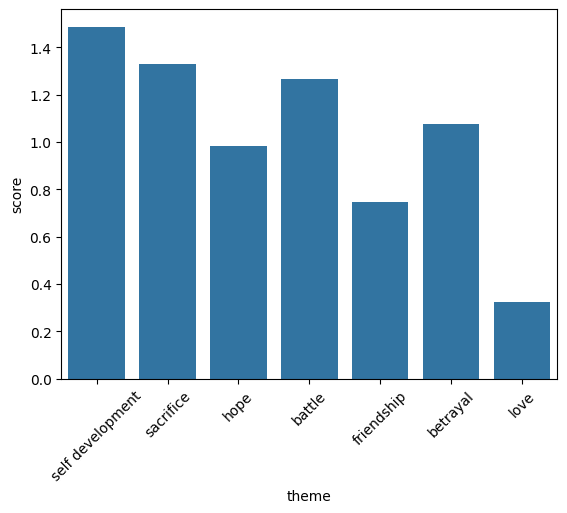

In [41]:
sns.barplot(data = theme_output ,x="theme",y="score" )
plt.xticks(rotation=45)
plt.show()